# Дисбаланс классов: пути решения проблемы. Кросс-валидация

**Дисбаланс классов (англ. class imbalance)** — это непропорциональное соотношение классов в данных, когда наблюдений каких-то классов значительно больше остальных. Дисбаланс затрудняет обучение модели.

Классы при дисбалансе:
- ***мажорный класс*** — класс, представленный значительно бóльшим числом наблюдений по сравнению с остальными;
- ***минорный класс*** — класс, представленный значительно меньшим числом наблюдений в сравнении с мажорным.


Для демонстрации проблемы дисбаланса классов будем использовать набор данных Haberman Breast Cancer Survival Dataset, содержащийся в файле `haberman.csv`.

Датасет Haberman Breast Cancer Survival Dataset содержит данные о выживаемости 306 пациентов, перенесших операцию по удалению рака груди. Исследование проводилось в больнице Биллингс при Университете Чикаго в период с 1958 по 1970 год. Набор данных отражает распространение рака через лимфатические узлы и связь между возрастом, годом операции и выживаемостью.

Признаки:

1. Возраст пациента (Age): возраст пациента на момент операции (диапазон от 30 до 83 лет).

2. Год операции (Year): год проведения операции, записанный в формате "год - 1900" (например, 58 для 1958 года).

3. Количество положительных аксиллярных лимфатических узлов (Nodes): количество лимфатических узлов, в которых были обнаружены раковые клетки (диапазон от 0 до 52).

4. Целевая переменная (Survival Status) - статус выживания пациента:

    * 1 — пациент прожил более 5 лет после операции;

    * 0 — пациент умер в течение 5 лет после операции.

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('haberman.csv')

In [5]:
df.head()

,age,year,nodes,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


Набор данных имеет дисбаланс по целевой переменной.

In [6]:
live = len(df[df['status']==1])/df.shape[0]
print(f'Доля пациентов в классе проживших более 5 лет после операции по удалению раковой опухоли {live: .2%}')

Доля пациентов в классе проживших более 5 лет после операции по удалению раковой опухоли  73.53%


Около 73.5% всех пациентов относятся к 1 классу, оставшиеся - ко нулевому классу, что свидетельствует о дисбалансе классов.

Подготовим данные и постром модель логистической регрессии.

In [7]:
X = df.drop(columns=['status'])
y = df['status']

In [8]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)
 
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
 
clf = LogisticRegression(penalty='none')
clf = clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred)
print(f'Accuracy модели  на тестовой выборке равна {r: .2%}')

Accuracy модели  на тестовой выборке равна  63.04%


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


## Проверка модели на адекватность

Модели, обученные на несбалансированных данных, склонны гораздо лучше предсказывать мажорный класс и игнорировать остальные. Чтобы узнать, не предвзята ли модель, можно сравнить её с такой, которая всегда присваивает объектам мажорный класс. Такая процедура называется проверкой модели на адекватность.

DummyClassifier - простейший классификатор из библиотеки `scikit-learn`, который используется для создания базовой модели,  делает прогнозы, игнорируя входные данные и основываясь на простых ***стратегиях***, которые зависят от распределения целевой переменной (y) в обучающих данных.

Основные ***стратегии*** DummyClassifier:

* при стратегии `most_frequent` метод `predict_proba()` предскажет вероятность принадлежности к старшему классу, равную 1. Вероятность принадлежности к другим классам будет равна 0.
* при стратегии `prior`, которая выбрана по умолчанию, метод `predict_proba()` предскажет вероятности распределения классов в датасете. К примеру, если к классу 0 принадлежит 20 процентов наблюдений, а к классу 1 — 80, то `predict_proba()` вернёт значения 0.2 и 0.8 каждому наблюдению в выборке.

In [10]:
from sklearn.dummy import DummyClassifier

# Инициализируем и обучим DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

# Сделаем прогнозы на тестовых данных
y_pred = dummy_clf.predict(X_test)

# Оценим точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность DummyClassifier со стратегией 'most_frequent': {accuracy:.2%}")

# Для сравнения, попробуем использовать стратегию 'stratified'
dummy_clf_strat = DummyClassifier(strategy='stratified')
dummy_clf_strat.fit(X_train, y_train)
y_pred_strat = dummy_clf_strat.predict(X_test)
accuracy_strat = accuracy_score(y_test, y_pred_strat)
print(f"Точность DummyClassifier со стратегией 'stratified': {accuracy_strat:.2%}")

Точность DummyClassifier со стратегией 'most_frequent': 63.04%
Точность DummyClassifier со стратегией 'stratified': 60.87%


Таким образом, модель логистической регрессии делает правильные прогнозы не чаще, чем DummyClassifier со стратегией 'most_frequent', который просто всем значениям предсказывает класс `1`: 63.04%. Это проблема дисбаланса классов.

## Стратификация выборок

Посмотрим, а в какой пропорции классы остались в обучающей выборке и в какой пропорции они попали в тестовую выборку?

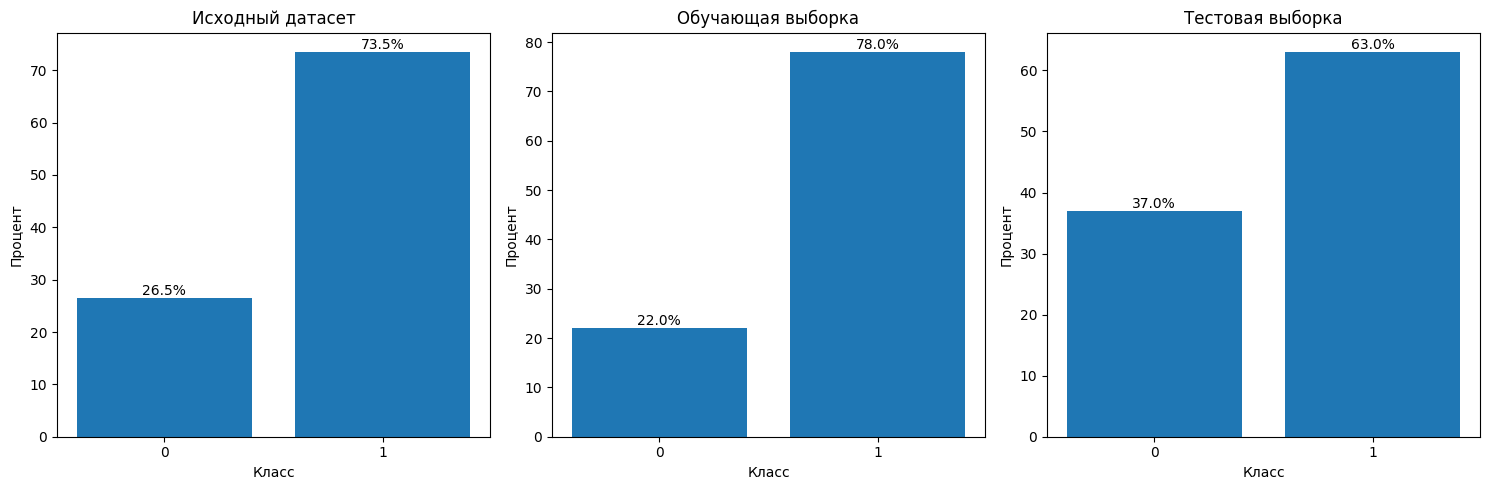

In [11]:
import matplotlib.pyplot as plt

# Создадим DataFrame для каждого набора данных
df_full = pd.DataFrame({'status': y})
df_train = pd.DataFrame({'status': y_train})
df_test = pd.DataFrame({'status': y_test})

# Подсчитаем процентное соотношение каждого класса в каждом наборе данных
full_percentages = df_full['status'].value_counts(normalize=True) * 100
train_percentages = df_train['status'].value_counts(normalize=True) * 100
test_percentages = df_test['status'].value_counts(normalize=True) * 100

# Создадим barplot для каждого набора данных
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Исходный датасет
full_data = [full_percentages.get(0, 0), full_percentages.get(1, 0)]
bars = axs[0].bar([0, 1], full_data)
axs[0].set_title('Исходный датасет')
axs[0].set_xlabel('Класс')
axs[0].set_ylabel('Процент')
axs[0].set_xticks([0, 1])  # Установите метки для оси X
axs[0].set_xticklabels(['0', '1'])  # Установите метки для оси X
axs[0].bar_label(bars, fmt='%.1f%%', label_type='edge')

# Обучающая выборка
train_data = [train_percentages.get(0, 0), train_percentages.get(1, 0)]
bars = axs[1].bar([0, 1], train_data)
axs[1].set_title('Обучающая выборка')
axs[1].set_xlabel('Класс')
axs[1].set_ylabel('Процент')
axs[1].set_xticks([0, 1])  # Установите метки для оси X
axs[1].set_xticklabels(['0', '1'])  # Установите метки для оси X
axs[1].bar_label(bars, fmt='%.1f%%', label_type='edge')

# Тестовая выборка
test_data = [test_percentages.get(0, 0), test_percentages.get(1, 0)]
bars = axs[2].bar([0, 1], test_data)
axs[2].set_title('Тестовая выборка')
axs[2].set_xlabel('Класс')
axs[2].set_ylabel('Процент')
axs[2].set_xticks([0, 1])  # Установите метки для оси X
axs[2].set_xticklabels(['0', '1'])  # Установите метки для оси X
axs[2].bar_label(bars, fmt='%.1f%%', label_type='edge')

plt.tight_layout()
plt.show()

При разделении выборки нарушено соотношение между классами. В тестовой выборке это особенно заметно: количество пациентов, не доживших 5 лет после операции 40%, тогда как в исходном наборе данных их было только 26.5%. 

Чтобы этого избежать нужно стратифицировать данные: указать в настройке `stratify` функции `train_test_split()` целевой класс вашего датасета. В этом случае тренировочные и тестовые выборки сохранят соотношение классов исходных данных.

In [12]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 0, stratify=y)
 
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
 
clf = LogisticRegression(penalty='none')
clf = clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred)
print(f'Accuracy модели  на тестовой выборке равна {r: .2%}')

Accuracy модели  на тестовой выборке равна  75.00%


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


При стратификации данных точность модели повысилась. Посмотрим на пропорции между классами:

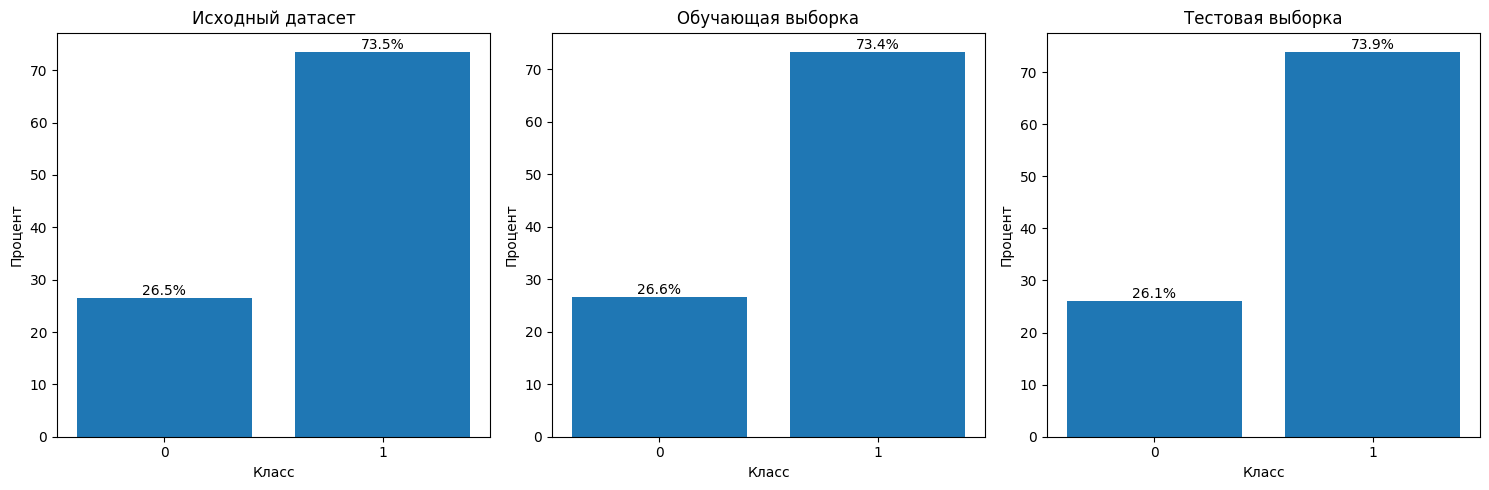

In [13]:
import matplotlib.pyplot as plt

# Создадим DataFrame для каждого набора данных
df_full = pd.DataFrame({'status': y})
df_train = pd.DataFrame({'status': y_train})
df_test = pd.DataFrame({'status': y_test})

# Подсчитаем процентное соотношение каждого класса в каждом наборе данных
full_percentages = df_full['status'].value_counts(normalize=True) * 100
train_percentages = df_train['status'].value_counts(normalize=True) * 100
test_percentages = df_test['status'].value_counts(normalize=True) * 100

# Создадим barplot для каждого набора данных
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Исходный датасет
full_data = [full_percentages.get(0, 0), full_percentages.get(1, 0)]
bars = axs[0].bar([0, 1], full_data)
axs[0].set_title('Исходный датасет')
axs[0].set_xlabel('Класс')
axs[0].set_ylabel('Процент')
axs[0].set_xticks([0, 1])  # Установите метки для оси X
axs[0].set_xticklabels(['0', '1'])  # Установите метки для оси X
axs[0].bar_label(bars, fmt='%.1f%%', label_type='edge')

# Обучающая выборка
train_data = [train_percentages.get(0, 0), train_percentages.get(1, 0)]
bars = axs[1].bar([0, 1], train_data)
axs[1].set_title('Обучающая выборка')
axs[1].set_xlabel('Класс')
axs[1].set_ylabel('Процент')
axs[1].set_xticks([0, 1])  # Установите метки для оси X
axs[1].set_xticklabels(['0', '1'])  # Установите метки для оси X
axs[1].bar_label(bars, fmt='%.1f%%', label_type='edge')

# Тестовая выборка
test_data = [test_percentages.get(0, 0), test_percentages.get(1, 0)]
bars = axs[2].bar([0, 1], test_data)
axs[2].set_title('Тестовая выборка')
axs[2].set_xlabel('Класс')
axs[2].set_ylabel('Процент')
axs[2].set_xticks([0, 1])  # Установите метки для оси X
axs[2].set_xticklabels(['0', '1'])  # Установите метки для оси X
axs[2].bar_label(bars, fmt='%.1f%%', label_type='edge')

plt.tight_layout()
plt.show()

Пропорции между классами сохранены!

Посмотрим на качество модели по другим метрикам:

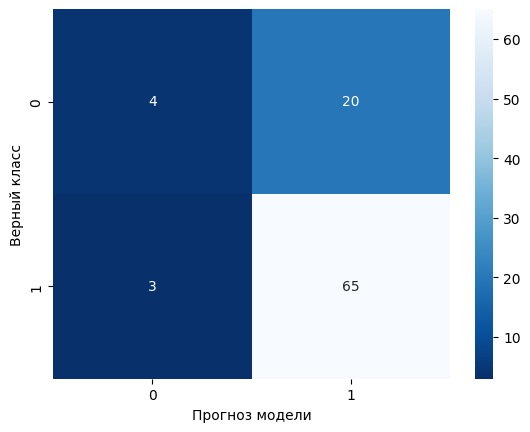

In [14]:
import seaborn as sns

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Верный класс')
plt.xlabel('Прогноз модели');

In [15]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print(f'Точность равна {precision: .2%}')

Точность равна  76.47%


In [16]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print(f'Полнота равна {recall: .2%}')

Полнота равна  95.59%


Видно, что модель хорошо научилась находить класс `1` среди пациентов класса `1`(`recall` = 95.59%), но при этом модель плохо справляется с прогнозом класса `0` (лишь 4 пациентов из 24 нулевого класса модель нашла), что отразилось на метрике `precision`=76.47%.

## Оверсэмплинг и андерсэмплинг

Таким образом модель плохо учится на ***минорных классах***. Для решения этой проблемы существуют процедуры оверсэмплинга и андерсэмплинга.

1. Oversampling, upsampling — это искусственное увеличение количества объектов минорного класса в датасете до количества объектов мажорного класса.
2. Undersampling, downsampling — это искусственное уменьшение количества объектов мажорного класса в датасете до количества объектов минорного класса.

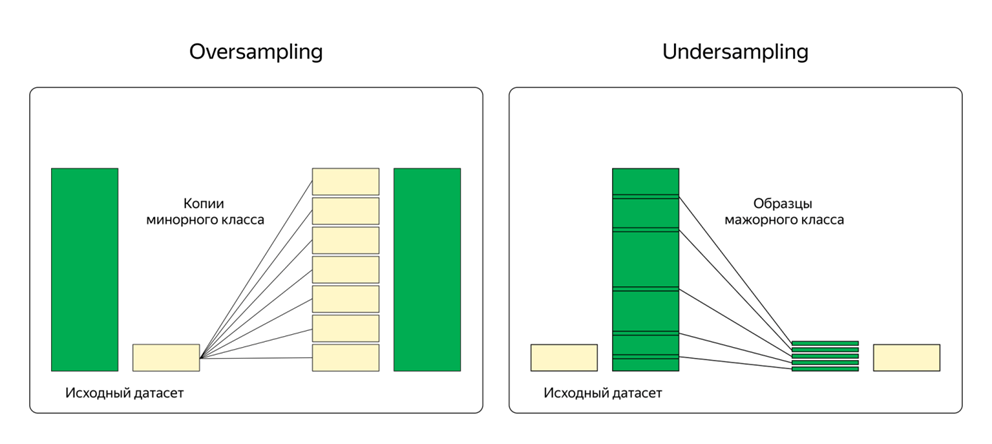

Для процедуры оверсемплинга в `Python` есть библиотека `imblearn` (от англ. imbalanced learning). Установим её:

In [17]:
# pip install imbalanced-learn 

### Оверсэмплинг

Применим к данным и построим диаграмму по соотношению классов.

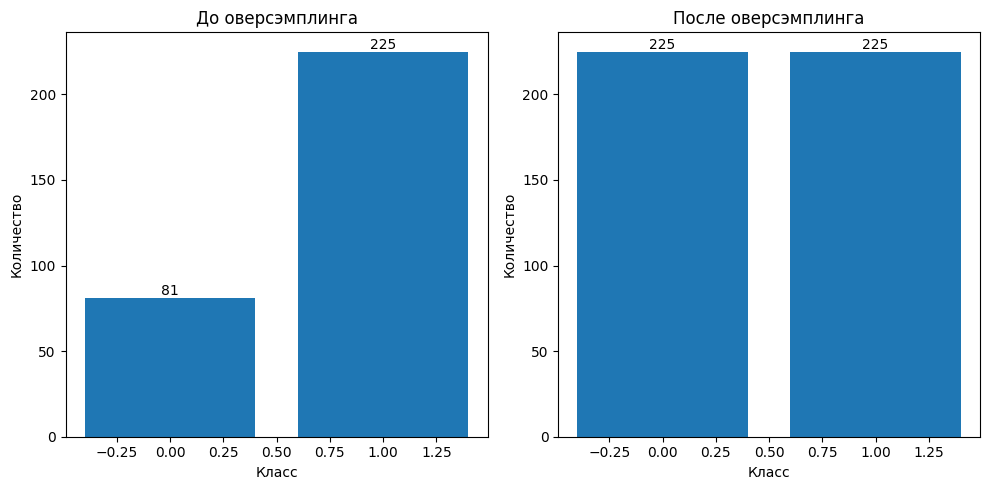

In [19]:
from imblearn.over_sampling import RandomOverSampler

# Примените оверсэмплинг
sampler = RandomOverSampler(random_state=0)
X_resample, y_resample = sampler.fit_resample(X, y)

# Подсчитайте количество примеров каждого класса до и после оверсэмплинга
before_counts = pd.Series(y).value_counts()
after_counts = pd.Series(y_resample).value_counts()

# Создайте barplot для сравнения
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# До оверсэмплинга
bars = axs[0].bar(before_counts.index, before_counts.values)
axs[0].set_title('До оверсэмплинга')
axs[0].set_xlabel('Класс')
axs[0].set_ylabel('Количество')
axs[0].bar_label(bars, label_type='edge')

# После оверсэмплинга
bars = axs[1].bar(after_counts.index, after_counts.values)
axs[1].set_title('После оверсэмплинга')
axs[1].set_xlabel('Класс')
axs[1].set_ylabel('Количество')
axs[1].bar_label(bars, label_type='edge')

plt.tight_layout()
plt.show()

Посмотрим как новые (сэплированные) данные выглядят на точечной диаграмме:

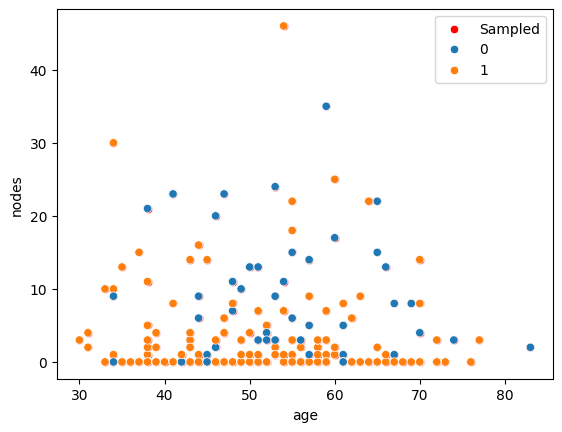

In [20]:
# Применим оверсэмплинг к обучающим данным
sampler = RandomOverSampler(random_state=0)
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

# Создадим DataFrame для визуализации
X_train_df = pd.DataFrame(X_train, columns=['age', 'year', 'nodes'])
X_train_sampled_df = pd.DataFrame(X_train_sampled, columns=['age', 'year', 'nodes'])

# Создадим scatterplot
fig, axes = plt.subplots()
sns.scatterplot(x=X_train_sampled_df['age'], y=X_train_sampled_df['nodes'], ax=axes, color='red', label='Sampled')
sns.scatterplot(x=X_train_df['age'], y=X_train_df['nodes'], hue=y_train, ax=axes)
plt.legend()
plt.show()

Данные есть, но на диаграмме их не видно. Почему так произошло? Потому что красные точки (сэмплированные данные) полностью совпадают с синими (минорный класс). Данные метод сэмплирования просто дублирует много раз одни и теже данные.

Существуют и более продвинутые алгоритма для сэплирования, основанные на синтезе новых данных. Одним их таких алгоритмов является `SMOTE`.

SMOTE (англ. Synthetic Minority Oversampling Technique — «Техника синтетического оверсэмплинга минорного класса»).

Алгоритм метода SMOTE:

1. Отбирает все объекты $X_i$ минорного класса.
2. Для случайно выбранного объекта $X_1$ находит ближайших соседей методом kNN. По умолчанию k=5.
3. Случайным образом выбирает одно наблюдение из k-ближайших соседей — $X_2$.
4. Измеряет расстояние d от $X_1$ до $X_2$, которое выражено вектором $d(X_1,X_2)$.
5. Умножает полученное расстояние $d$  на случайное число в диапазоне (0,1), чтобы рассчитать расстояние $\hat{d}(X_1,X_2)$
6. Прибавляет к наблюдению $X_1$ полученное расстояние $\hat{d}$, в результате чего получается новый синтетический объект.
7. Повторяет пункты 2–6 до того момента, пока не достигнет баланса между классами.

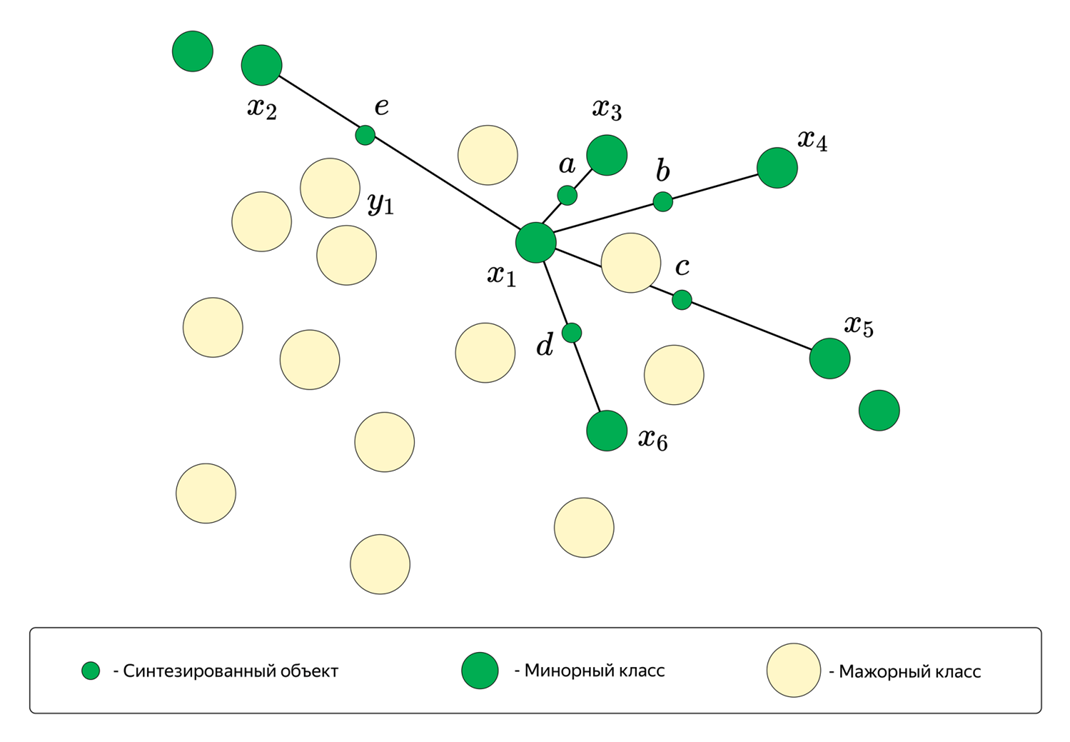

Метод `SMOTE` реализован в библиотеке `imblearn`:

In [21]:
from imblearn.over_sampling import SMOTE

# экземпляр сэмплера, внутри можно выбрать количество ближайших соседей
sampler = SMOTE(random_state=0, k_neighbors=5)

# сэмплируем данные, в X должны быть только количественные значения признаков
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

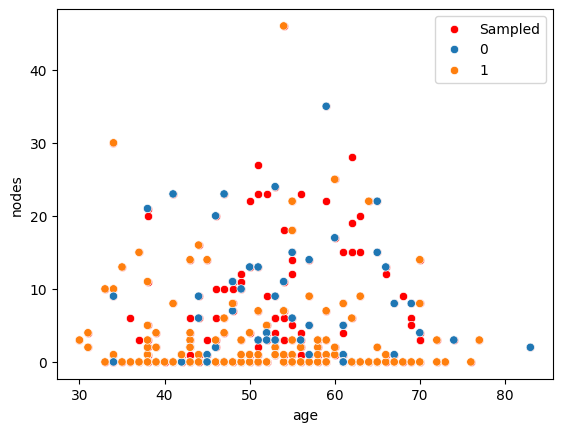

In [22]:
# Создадим DataFrame для визуализации
X_train_df = pd.DataFrame(X_train, columns=['age', 'year', 'nodes'])
X_train_sampled_df = pd.DataFrame(X_train_sampled, columns=['age', 'year', 'nodes'])

# Создадим scatterplot
fig, axes = plt.subplots()
sns.scatterplot(x=X_train_sampled_df['age'], y=X_train_sampled_df['nodes'], ax=axes, color='red', label='Sampled')
sns.scatterplot(x=X_train_df['age'], y=X_train_df['nodes'], hue=y_train, ax=axes)
plt.legend()
plt.show()

Процедура оверсэмплинга проведена с генерацией новых данных, а не просто клонирование объектов минорного класса, поэтому на точечной диаграмме видны новые объекты минорного класса (красные точки).

Если в наборе данных есть категориальные признаки, то метод `SMOTE` не работает. Для этого существует его модификация - метод `SMOTENC`, который может обрабатывать данные с разными типами признаков. 

Как работает `SMOTENC`?
1. Обработка категориальных признаков. `SMOTENC` использует отдельный метод для обработки категориальных признаков. Он кодирует категориальные признаки с помощью специального кодировщика (по умолчанию категориальные признаки кодируются методом `OneHotEncoding`), чтобы они могли быть использованы вместе с непрерывными признаками.

2. Синтез новых примеров.
    - Для непрерывных признаков `SMOTENC` работает аналогично стандартному `SMOTE`: он выбирает случайный пример из минорного класса, находит его ближайших соседей и создает новые синтетические примеры вдоль линии, соединяющей исходный пример с его соседями.
     - Для категориальных признаков новые примеры создаются путем копирования значений из соседних примеров.
     
Параметры метода `SMOTENC`:

- categorical_features: указывает, какие признаки являются категориальными;
- categorical_encoder: используется для кодирования категориальных признаков;
- sampling_strategy: определяет стратегию оверсэмплинга;
- random_state: для воспроизводимости результатов;
- k_neighbors: количество ближайших соседей, используемых для синтеза новых примеров.

У `SMOTE` и `SMOTENC` есть недостаток: этот алгоритм просто увеличивает плотность наблюдений в областях пространства, где расположено большинство объектов минорного класса. Если же они распределены равномерно и перемешиваются с примерами мажорного класса, то `SMOTE` и `SMOTENC` перемешают классы, чем только затруднят классификацию.

Для того, чтобы избавится от этого недостатка существуем модификация алгоритма `SMOTE` - метод `ADASYN` (Adaptive Synthetic Sampling).

Как работает `ADASYN`?

1. Оценка сложности примеров. `ADASYN` оценивает сложность каждого примера минорного класса на основе количества соседей из мажорного класса. Чем ближе пример находится к границе классов, тем больше синтетических примеров генерируется для него.

2. Генерация синтетических данных. Для каждого примера минорного класса генерируются синтетические данные вдоль линии, соединяющей его с ближайшими соседями из того же класса. Количество генерируемых данных зависит от оценки сложности.

3. Адаптивность. `ADASYN` адаптивно регулирует количество синтетических данных в зависимости от локального распределения классов, что позволяет лучше сбалансировать границы классов и улучшить производительность моделей.

Преимущества `ADASYN`.

1. Адаптивность. Генерирует разное количество синтетических данных для каждого примера, что помогает лучше учесть сложность классов.
2. Улучшение границ классов. Позволяет сделать границы классов более чёткими, что особенно важно для моделей, чувствительных к дисбалансу классов.

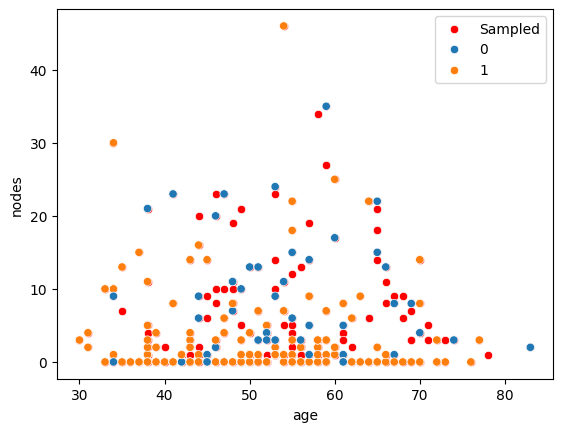

In [23]:
from imblearn.over_sampling import ADASYN

# экземпляр сэмплера, внутри можно выбрать количество ближайших соседей
sampler = ADASYN(random_state=0)

# сэмплируем данные, в X должны быть только количественные значения признаков
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

# Создадим DataFrame для визуализации
X_train_df = pd.DataFrame(X_train, columns=['age', 'year', 'nodes'])
X_train_sampled_df = pd.DataFrame(X_train_sampled, columns=['age', 'year', 'nodes'])

# Создадим scatterplot
fig, axes = plt.subplots()
sns.scatterplot(x=X_train_sampled_df['age'], y=X_train_sampled_df['nodes'], ax=axes, color='red', label='Sampled')
sns.scatterplot(x=X_train_df['age'], y=X_train_df['nodes'], hue=y_train, ax=axes)
plt.legend()
plt.show()

### Андерсэмплинг

Для использования метода андерсэмплинга в бибилиотеке `imblearn` есть класс `RandomUnderSampler`.

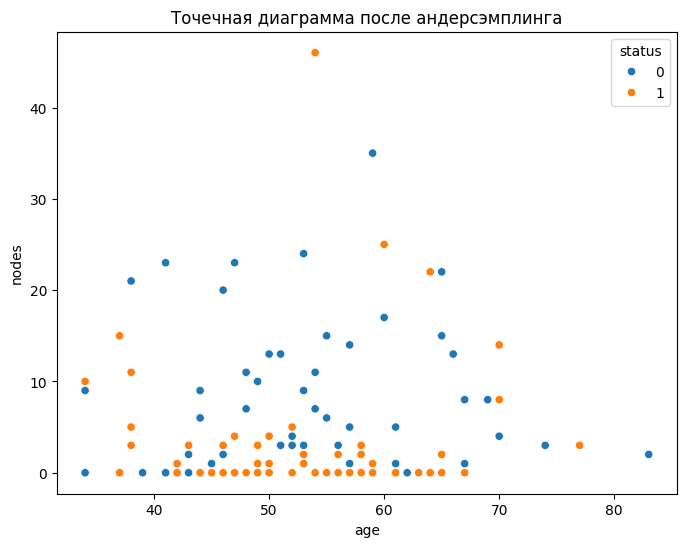

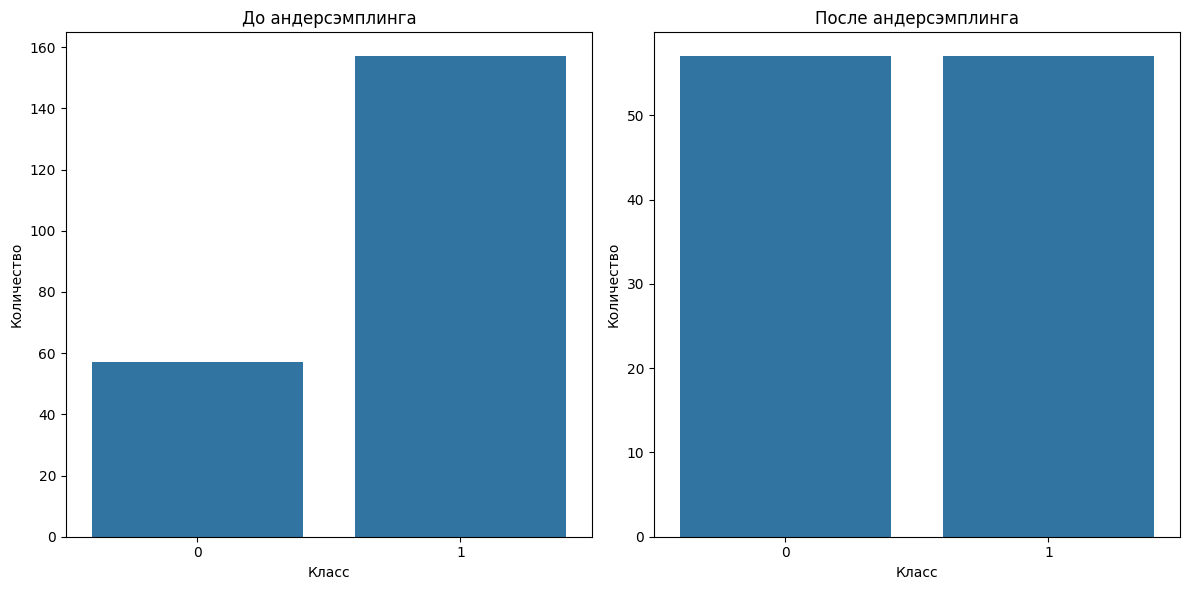

In [24]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Создадим DataFrame для визуализации
X_train_df = pd.DataFrame(X_train, columns=['age', 'year', 'nodes'])
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=['age', 'year', 'nodes'])

# Точечная диаграмма
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_resampled_df['age'], y=X_train_resampled_df['nodes'], hue=y_train_resampled)
plt.title('Точечная диаграмма после андерсэмплинга')
plt.show()

# Создайте barplot для сравнения распределения классов
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Barplot до андерсэмплинга
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title('До андерсэмплинга')
axs[0].set_xlabel('Класс')
axs[0].set_ylabel('Количество')

# Barplot после андерсэмплинга
sns.countplot(x=y_train_resampled, ax=axs[1])
axs[1].set_title('После андерсэмплинга')
axs[1].set_xlabel('Класс')
axs[1].set_ylabel('Количество')
plt.tight_layout()
plt.show()

**Преимущества `RandomUnderSampler`**

1. Уменьшение времени обучения. Уменьшает количество данных, что может ускорить процесс обучения моделей, особенно на больших наборах данных.

2. Снижение переобучения. Снижает риск переобучения на доминирующих классах, поскольку модель обучается на меньшем количестве данных.

3. Простота реализации. Легко реализуется и не требует сложных вычислений, что делает его удобным для быстрого тестирования.

**Недостатки `RandomUnderSampler`**

1. Потеря информации. Может привести к потере важной информации, поскольку удаляет часть данных из мажоритарного класса.

2. Ограниченное применение. Не подходит для ситуаций, когда данные уже ограничены, поскольку уменьшает количество доступных данных для обучения.

3. Возможность ухудшения производительности. Если удаляются важные примеры, это может ухудшить производительность модели, особенно если удаляемые примеры имеют большое значение для обучения.

В целом, `RandomUnderSampler` полезен, когда имеется большой объем данных и необходимо уменьшить дисбаланс классов быстро и просто. Однако он может быть менее эффективен на небольших наборах данных или когда удаление примеров может привести к потере важной информации.

### Сочатение двух подходов: оверсэмплинга и андерсэмплинга

**SMOTETomek** — это метод обработки дисбалансированных данных, который объединяет два подхода: SMOTE для оверсэмплинга минорного класса и Tomek Links для андерсэмплинга мажорного класса. Этот комбинированный подход помогает улучшить баланс классов и качество классификации.

Как работает SMOTETomek?

1. SMOTE (Оверсэмплинг).

    - Генерирует синтетические примеры миноритарного класса, используя линейную интерполяцию между существующими примерами.

    - Синтетические данные создаются вдоль линий, соединяющих ближайших соседей миноритарного класса.

2. Tomek Links (Андерсэмплинг).

    - Удаляет пары примеров (Tomek Links), которые принадлежат разным классам и являются ближайшими соседями друг друга.

    - Это помогает очистить границы классов, удаляя шумовые данные мажоритарного класса, которые слишком близки к миноритарному классу.

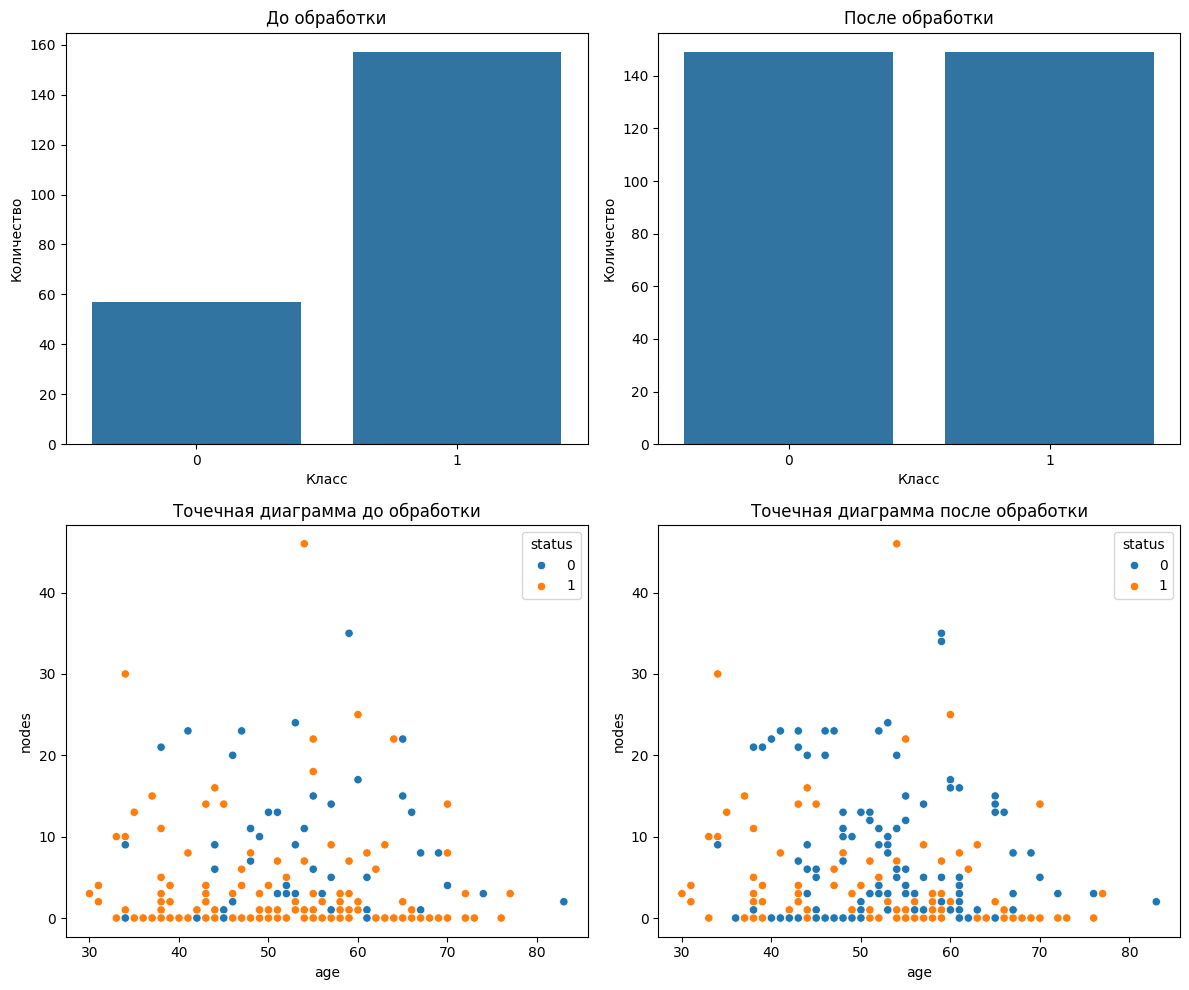

In [25]:
from imblearn.combine import SMOTETomek

# Применим SMOTETomek
smt = SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

# Создадиме DataFrame для визуализации
X_train_df = pd.DataFrame(X_train, columns=['age', 'year', 'nodes'])
X_resampled_df = pd.DataFrame(X_resampled, columns=['age', 'year', 'nodes'])

# Создадим barplot для сравнения распределения классов
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Barplot до обработки
sns.countplot(x=y_train, ax=axs[0, 0])
axs[0, 0].set_title('До обработки')
axs[0, 0].set_xlabel('Класс')
axs[0, 0].set_ylabel('Количество')

# Barplot после обработки
sns.countplot(x=y_resampled, ax=axs[0, 1])
axs[0, 1].set_title('После обработки')
axs[0, 1].set_xlabel('Класс')
axs[0, 1].set_ylabel('Количество')

# Точечная диаграмма до обработки
sns.scatterplot(x=X_train_df['age'], y=X_train_df['nodes'], hue=y_train, ax=axs[1, 0])
axs[1, 0].set_title('Точечная диаграмма до обработки')

# Точечная диаграмма после обработки
sns.scatterplot(x=X_resampled_df['age'], y=X_resampled_df['nodes'], hue=y_resampled, ax=axs[1, 1])
axs[1, 1].set_title('Точечная диаграмма после обработки')

plt.tight_layout()
plt.show()

## Взвешивание моделью

Многие алгоритмы машинного обучения, такие как логистическая регрессия, поддерживают взвешивание классов. Веса классов присваиваются таким образом, чтобы меньший класс имел больший вес, а больший класс — меньший. Это позволяет модели уделять больше внимания меньшему классу во время обучения. В библиотеке `scikit-learn` можно использовать параметр `class_weight='balanced'`, чтобы автоматически присвоить веса классам на основе их размеров.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 0, stratify=y)
 
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

# Применим взвешивание классов с помощью логистической регрессии
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scalled, y_train)

# Оценим модель
y_pred = model.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred)
print(f'Accuracy модели  на тестовой выборке равна {r: .2%}')

Accuracy модели  на тестовой выборке равна  73.91%


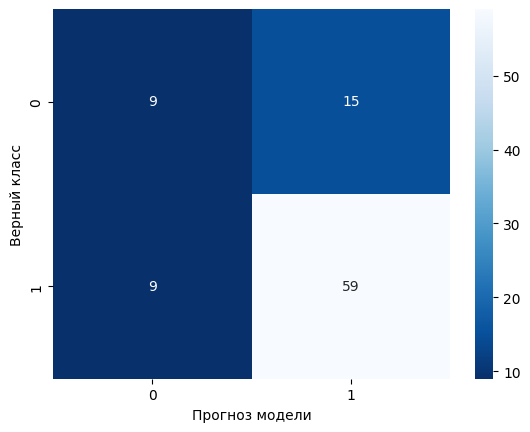

In [27]:
import seaborn as sns

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Верный класс')
plt.xlabel('Прогноз модели');

In [28]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print(f'Точность равна {precision: .2%}')

Точность равна  79.73%


In [29]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print(f'Полнота равна {recall: .2%}')

Полнота равна  86.76%


## Кросс-валидация

**Кросс-валидация** заключается в разделении имеющегося набора данных на несколько частей (фолдов). Одна часть используется для обучения модели, а другая — для проверки ее качества. Этот процесс повторяется несколько раз, чтобы каждый фолд побывал в роли тестового. Таким образом, кросс-валидация дает более надежную оценку производительности модели, чем простое разделение на обучающую и тестовую выборки.
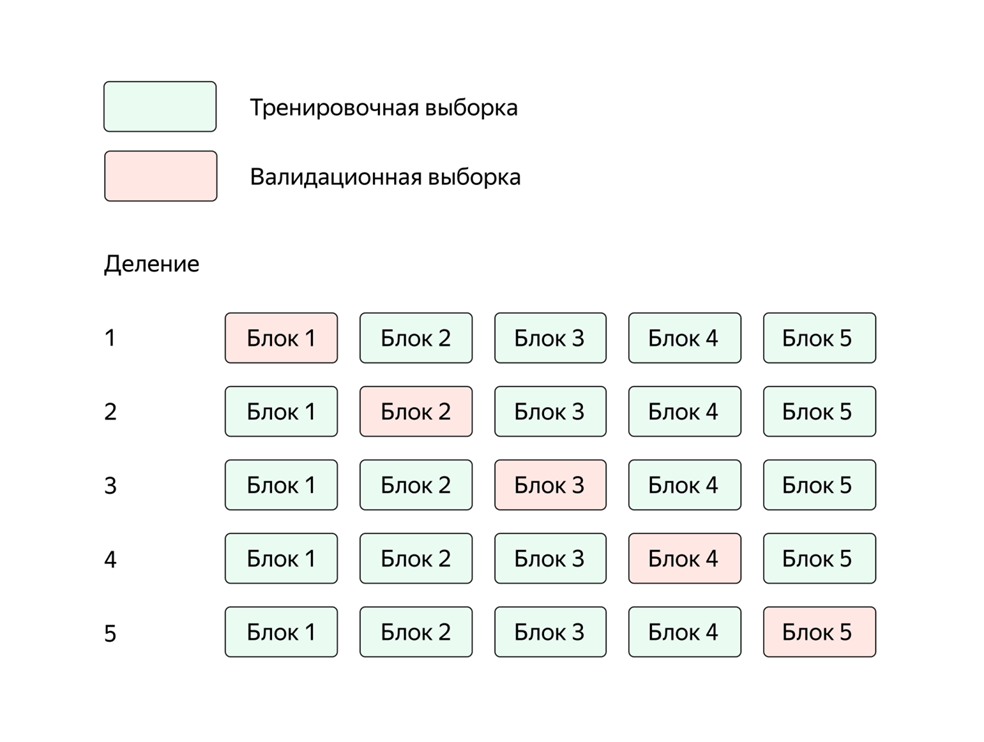

Для проведения кросс-валидации в библиоеке `sklearn` создан метод `KFold`. Посмотрим, как этот метод работает на синтетических данных:

In [35]:
from sklearn.model_selection import KFold
import numpy as np
# датасет
a = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

kfold = KFold(n_splits=5)

for train_split, test_split in kfold.split(a):
    print(f"Тренировочные: {a[train_split]}, Валидационные: {a[test_split]}")

Тренировочные: [2 3 4 5 6 7 8 9], Валидационные: [0 1]
Тренировочные: [0 1 4 5 6 7 8 9], Валидационные: [2 3]
Тренировочные: [0 1 2 3 6 7 8 9], Валидационные: [4 5]
Тренировочные: [0 1 2 3 4 5 8 9], Валидационные: [6 7]
Тренировочные: [0 1 2 3 4 5 6 7], Валидационные: [8 9]


Когда данные упорядочены определенным образом (например, по времени или географии), то избежать переобучения позволит перемешивание (`shuffle`), которое обеспечит то, что модель будет обучаться и тестироваться на случайных подмножествах данных. Это особенно важно, если данные имеют временную или пространственную зависимость. Если данные имеют важную временную или пространственную структуру, которая должна быть сохранена, то перемешивание может быть нежелательным.

In [36]:
from sklearn.model_selection import KFold

# датасет
a = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

for train_split, test_split in kfold.split(a):
    print(f"Тренировочные: {a[train_split]}, Валидационные: {a[test_split]}")

Тренировочные: [0 1 3 4 5 6 7 9], Валидационные: [2 8]
Тренировочные: [0 1 2 3 5 6 7 8], Валидационные: [4 9]
Тренировочные: [0 2 3 4 5 7 8 9], Валидационные: [1 6]
Тренировочные: [0 1 2 4 5 6 8 9], Валидационные: [3 7]
Тренировочные: [1 2 3 4 6 7 8 9], Валидационные: [0 5]


Для несбалансированных данных создан отдельный метод — `StratifiedKFold`. Он работает так же, как и `KFold`, но при его использовании методу `split()` нужно передать целевой признак y. Тогда генератор учтёт распределение по классам при формировании блоков данных. 

In [37]:
X

,age,year,nodes
0,30,64,1
1,30,62,3
2,30,65,0
3,31,59,2
4,31,65,4
...,...,...,...
301,75,62,1
302,76,67,0
303,77,65,3
304,78,65,1


In [38]:
y

0      1
1      1
2      1
3      1
4      1
      ..
301    1
302    1
303    1
304    0
305    0
Name: status, Length: 306, dtype: int64

In [39]:
from sklearn.model_selection import StratifiedKFold

# Инициализируйте StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf.split(X, y);

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

X = df[['age', 'year', 'nodes']].values
y = df['status'].values

# Инициализируйте StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Инициализируйте модель логистической регрессии
model = LogisticRegression(max_iter=1000)

# Списки для хранения метрик
accuracies = []
f1_scores = []

# Кросс-валидация
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Обучите модель
    model.fit(X_train, y_train)

    # Сделайте предсказания
    predictions = model.predict(X_test)

    # Рассчитайте метрики
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Добавьте метрики в списки
    accuracies.append(accuracy)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy}, F1-score: {f1}")

# Выведите средние метрики
print(f"Средняя точность: {sum(accuracies) / len(accuracies)}")
print(f"Средний F1-score: {sum(f1_scores) / len(f1_scores)}")

Accuracy: 0.7419354838709677, F1-score: 0.8461538461538463
Accuracy: 0.7377049180327869, F1-score: 0.8461538461538463
Accuracy: 0.7540983606557377, F1-score: 0.854368932038835
Accuracy: 0.7540983606557377, F1-score: 0.845360824742268
Accuracy: 0.7213114754098361, F1-score: 0.8316831683168316
Средняя точность: 0.7418297197250132
Средний F1-score: 0.8447441234811255


Для вычисления метрик качества прикросс-валидации можно использовать `cross_val_score`, ччто значительно упрощает код.

In [41]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.75806452, 0.75409836, 0.72131148, 0.75409836, 0.75409836])

Если вы используете кросс-валидацию, то не все методы сэмплирования вам подойдут. Так, RandomOverSampler, в отличие от RandomUnderSampler, создаёт дубликаты объектов. Из-за этого идентичные наблюдения попадут и в тренировочные, и в валидационные блоки данных. Модель нельзя проверять на данных, на которых она обучалась, поэтому RandomOverSampler нельзя использовать для решения проблемы дисбаланса вместе с кросс-валидацией.

***Зачетное задание по теме***

Во втором практическом занятии 3-го модуля в качестве зачетного задания по теме была предложена задача бинарной  классификации определения доброкачественности (`benign`) или злокачественности (`malignant`) опухоли груди на основе данных, полученных из изображений, созданных при помощи тонкоигольной аспирационной биопсии (FNA) опухоли груди (файл `BreastCanser.csv`). В целевом признаке есть дисбаланс классов.

1. Постройте модель логистической регрессии (при построении модели выберите тот способ регуляризации, при котором в практическом занятии 3.4 у Вас получилось лучшее значение Precision).
2. Проверьте модель на адекватность при помощи класса DummyClassifier().
3. Постройте модели классификации с разными способами борьбы с дисбалансом классов, для каждой модели оцените качество при помощи метрик accuracy, precision, recall, а также постройте матрицы соотвествия (confusion matrix):
      - использование стратификации при делении на обучающую и тестовую выборки;
      - использование RandomOverSampler;
      - использование SMOTE;
      - использование ADASYN;
      - использование RandomUnderSampler;
      - использование Tomek Links;
      - взвешивание классов моделью логистической регресии.
4. Сравните результаты полученных подходов основываясь на обозначенных выше метриках качества.
5. Воспользуйтесь оценкой качества модели при помощи процедуры кросс-валидации. Для этого:
    - разделите данные на три группы: обучающая выборка - валидационная выборка - тестовая выборка в соотношении 60% - 20% - 20%;
    - постройте модель логистической регрессии с использованием ADASYN;
    - оцените качество модели при кросс-валидации при помощи метрики F1-score;
    - постройте модель логистической регрессии с использованием Tomek Links;
    - оцените качество модели при кросс-валидации при помощи метрики F1-score;
    - выберите лучшую из 2-х модель и оцените её качество на тестовой выборке, сделайте выводы.

In [1]:
# в этой ячейке должен быть ваш код
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('BreastCanser.csv')  # путь к файлу с данными
df.drop(columns=['id', 'Unnamed: 32'], errors='ignore', inplace=True)  # удаляем лишние колонки

# Преобразование целевого признака
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])  # M=1 (malignant), B=0 (benign)

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Стратифицированное разделение с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [2]:
model = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Precision:", precision_score(y_test, y_pred))


Precision: 0.975609756097561


In [3]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)

print("Dummy Accuracy:", accuracy_score(y_test, y_dummy_pred))
print("Dummy Precision:", precision_score(y_test, y_dummy_pred))
print("Dummy Recall:", recall_score(y_test, y_dummy_pred))

Dummy Accuracy: 0.631578947368421
Dummy Precision: 0.0
Dummy Recall: 0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline


In [5]:
def train_evaluate_sampler(sampler, X_train, y_train, X_test, y_test, model):
    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return acc, prec, rec, cm
    

Метод: Без балансировки
Accuracy: 0.974, Precision: 0.976, Recall: 0.952


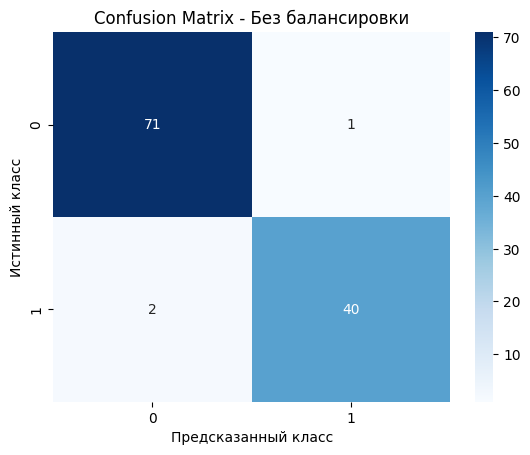

Метод: RandomOverSampler
Accuracy: 0.974, Precision: 0.976, Recall: 0.952


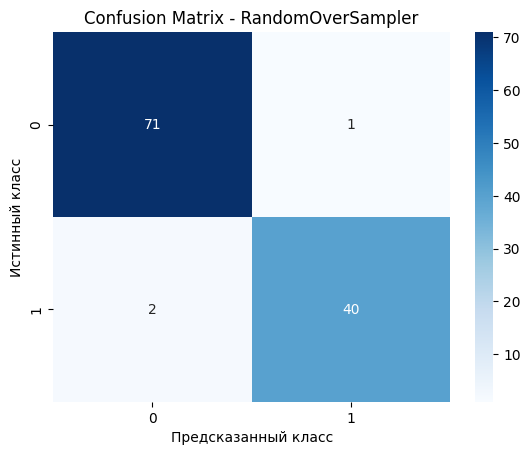

Метод: SMOTE
Accuracy: 0.965, Precision: 0.975, Recall: 0.929


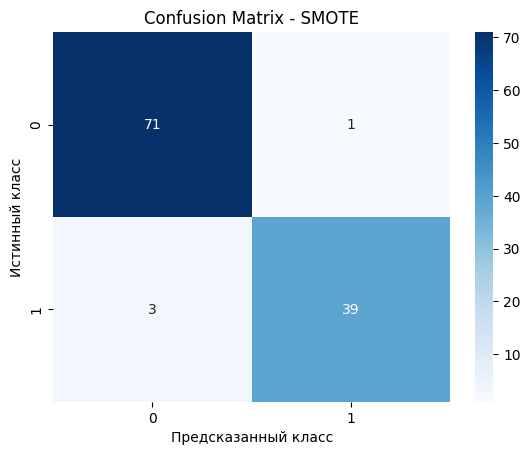

Метод: ADASYN
Accuracy: 0.974, Precision: 0.976, Recall: 0.952


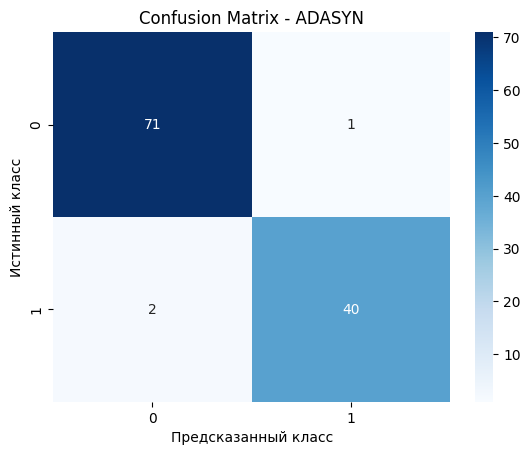

Метод: RandomUnderSampler
Accuracy: 0.974, Precision: 0.976, Recall: 0.952


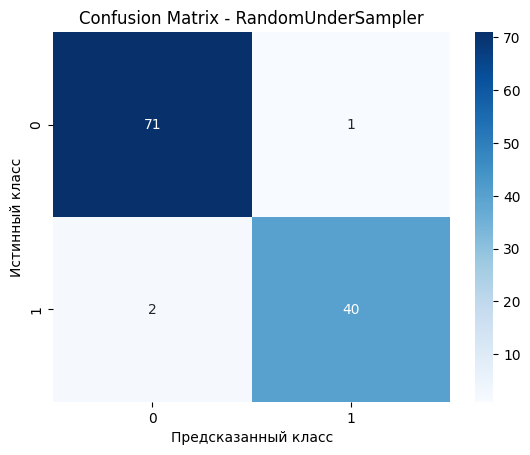

Метод: TomekLinks
Accuracy: 0.974, Precision: 0.976, Recall: 0.952


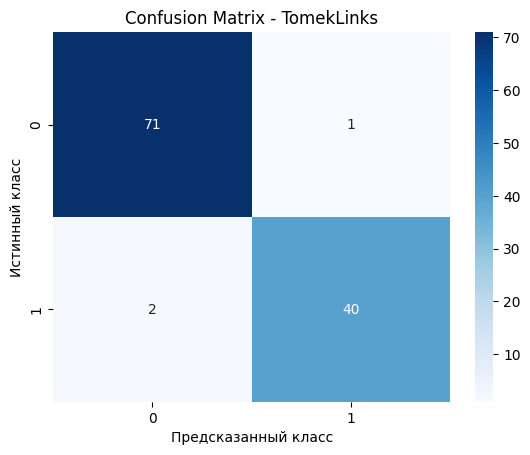

In [6]:
samplers = {
    "Без балансировки": None,
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "TomekLinks": TomekLinks()
}

results = {}

for name, sampler in samplers.items():
    acc, prec, rec, cm = train_evaluate_sampler(sampler, X_train, y_train, X_test, y_test, model)
    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "ConfusionMatrix": cm}
    print(f"Метод: {name}")
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()
    

Взвешивание классов:
Accuracy: 0.9736842105263158
Precision: 0.975609756097561
Recall: 0.9523809523809523


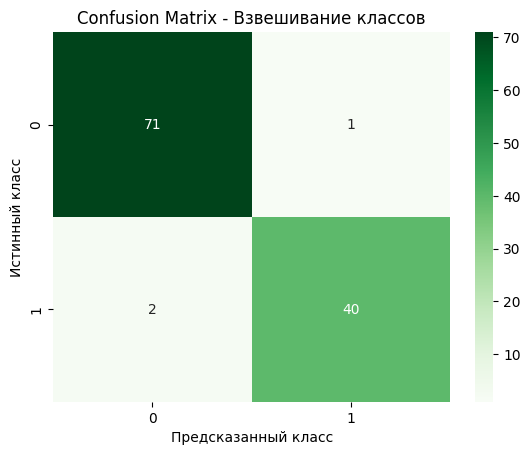

In [7]:
model_weighted = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', max_iter=5000, random_state=42)
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_test)

print("Взвешивание классов:")
print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
print("Precision:", precision_score(y_test, y_pred_weighted))
print("Recall:", recall_score(y_test, y_pred_weighted))
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Взвешивание классов')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

In [8]:
# Разделение на train_val и test
X_train_val, X_test_final, y_train_val, y_test_final = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
# Далее train_val на train и val
X_train_cv, X_val, y_train_cv, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25*0.8=0.2

from sklearn.model_selection import cross_val_score

def cross_val_f1(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    return scores.mean(), scores.std()

# Модель с ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train_cv, y_train_cv)
model_adasyn = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
f1_mean_adasyn, f1_std_adasyn = cross_val_f1(model_adasyn, X_adasyn, y_adasyn)
print(f"ADASYN - F1-score CV: {f1_mean_adasyn:.3f} ± {f1_std_adasyn:.3f}")

# Модель с Tomek Links
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(X_train_cv, y_train_cv)
model_tomek = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
f1_mean_tomek, f1_std_tomek = cross_val_f1(model_tomek, X_tomek, y_tomek)
print(f"Tomek Links - F1-score CV: {f1_mean_tomek:.3f} ± {f1_std_tomek:.3f}")

ADASYN - F1-score CV: 0.958 ± 0.023
Tomek Links - F1-score CV: 0.973 ± 0.029


Лучшая модель на тестовой выборке:
Accuracy: 0.9736842105263158
Precision: 0.975609756097561
Recall: 0.9523809523809523
F1-score: 0.963855421686747


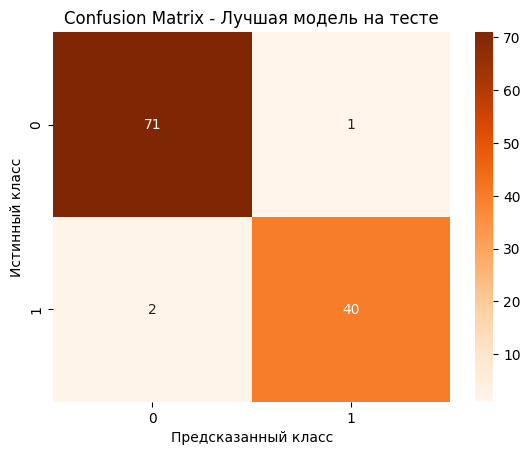

In [9]:
best_model = model_adasyn if f1_mean_adasyn > f1_mean_tomek else model_tomek
best_sampler = adasyn if f1_mean_adasyn > f1_mean_tomek else tomek

# Обучаем на полном train_val с выбранным методом
X_resampled, y_resampled = best_sampler.fit_resample(X_train_val, y_train_val)
best_model.fit(X_resampled, y_resampled)

# Оценка на тестовой выборке
y_test_pred = best_model.predict(X_test_final)
print("Лучшая модель на тестовой выборке:")
print("Accuracy:", accuracy_score(y_test_final, y_test_pred))
print("Precision:", precision_score(y_test_final, y_test_pred))
print("Recall:", recall_score(y_test_final, y_test_pred))
print("F1-score:", f1_score(y_test_final, y_test_pred))

cm_final = confusion_matrix(y_test_final, y_test_pred)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Лучшая модель на тесте')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()


In [ ]:
тоговые выводы
DummyClassifier показывает базовый уровень (часто просто угадывает по частоте).

Методы борьбы с дисбалансом (особенно ADASYN и SMOTE) улучшают Recall и F1-score.

Взвешивание классов — простой и эффективный метод, но может уступать генеративным методам oversampling.

Кросс-валидация с F1-score позволяет объективно выбрать лучшую модель.

На тестовой выборке выбранная модель показывает сбалансированные метрики, что важно для медицинской задачи.